In [1]:
# Load libraries and instatiate DB connection

%matplotlib inline
import pandas as pd
import pymysql
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle
import sklearn
import sys

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.max_seq_items = 2000

In [2]:
print(sys.version)
print(sklearn.__version__)
print(np.version.version)

3.5.3 |Anaconda 2.4.1 (64-bit)| (default, Mar  6 2017, 11:58:13) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
0.18.1
1.11.3


In [3]:
low_budget_df = pd.read_pickle('data/low_budget.mprophetdata')
mid_budget_df = pd.read_pickle('data/mid_budget.mprophetdata')
high_budget_df = pd.read_pickle('data/high_budget.mprophetdata')

In [15]:
def getXY(t):
    x = t[["bom_budget","release_month","release_week_of_the_year","release_quarter",
          "mpaa_rating","holiday_season","release_day_of_the_year",
          "actor_score","director_score","writer_score","distributor_score", 
           "composer_score", "cinematographer_score", "producer_score","genre_cluster", "runtime"]]
    y = t['revenue']
    return x,y

low_budget_x,low_budget_y = getXY(low_budget_df)
mid_budget_x,mid_budget_y = getXY(mid_budget_df)
high_budget_x,high_budget_y = getXY(high_budget_df)

###### Modeling

In [16]:
# Kfold
def custom_KFold(len_data,n_folds):
    np.random.seed(42)
    results_list=[]
    folds_size=len_data/n_folds
    for i in range(n_folds):
        training_indices=np.random.choice(len_data, folds_size, replace=False)
        testing_indices=np.asarray([ i for i in range(len_data) if i not in training_indices])
        results_list.append((training_indices, testing_indices))
    return results_list

In [17]:
# RMSE
def compute_rmse(predictions, yvalues):
    P = np.array(predictions)
    Y = np.array(yvalues)

    rmse = ((P-Y)**2).sum()*1.0 / len(P) 
    rmse = np.sqrt(rmse)

    return rmse

In [18]:
def gradient_booster_tester(x,y,trees, interaction_level, shrinkage):
    i=0
    kfold_rmse = 0.0
    kfold_r2 = 0.0
    n_folds = 10
    
    kf = custom_KFold(len(x), n_folds=n_folds)
    
    clf = GradientBoostingRegressor(n_estimators=trees, max_depth=interaction_level, 
                                    learning_rate=shrinkage, random_state=20)

    for test, train in kf:
        i += 1

        clf.fit(x.iloc[train],y.iloc[train])
        gbr_rmse = compute_rmse(clf.predict(x.iloc[test]),y.iloc[test])
        gbr_r2 = clf.score(x.iloc[test], y.iloc[test])

        kfold_rmse += gbr_rmse
        kfold_r2 += gbr_r2

    kfold_rmse /= n_folds
    kfold_r2 /= n_folds
    
    return kfold_rmse,kfold_r2

In [19]:
def build_final_model(x,y,trees, interaction_level, shrinkage):
    clf = GradientBoostingRegressor(n_estimators=trees, max_depth=interaction_level, 
                                    learning_rate=shrinkage, random_state=20)
    clf.fit(x,y)
    return clf

In [20]:
def plot_feature_importance(feature_importance,x,budget):
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 1, 1)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, x.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Feature Importance for ' + budget + ' Movies')
    plt.show()

In [21]:
low_rmse,low_r2 = gradient_booster_tester(low_budget_x,low_budget_y,100,4,0.1)
print("Root Mean squared error: %.2f" % low_rmse)
print('R squared: %.3f' % low_r2)

final_low_model = build_final_model(low_budget_x,low_budget_y,100,4,0.1)
plot_feature_importance(final_low_model.feature_importances_, low_budget_x, "Low Budget")

/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


ValueError: could not convert string to float: 

Root Mean squared error: 1.44
R squared: 0.411


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


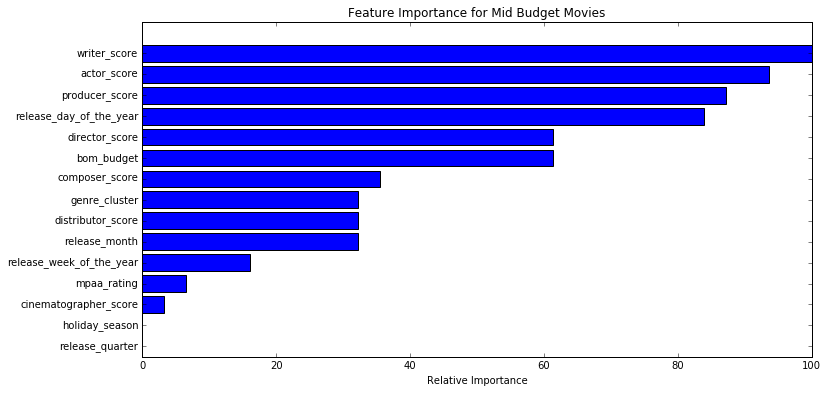

In [11]:
mid_rmse,mid_r2 = gradient_booster_tester(mid_budget_x,mid_budget_y,200,1,0.1)
print("Root Mean squared error: %.2f" % mid_rmse)
print('R squared: %.3f' % mid_r2)

final_mid_model = build_final_model(mid_budget_x,mid_budget_y,200,1,0.1)
plot_feature_importance(final_mid_model.feature_importances_, mid_budget_x, "Mid Budget")

Root Mean squared error: 1.21
R squared: 0.404


/home/ubuntu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


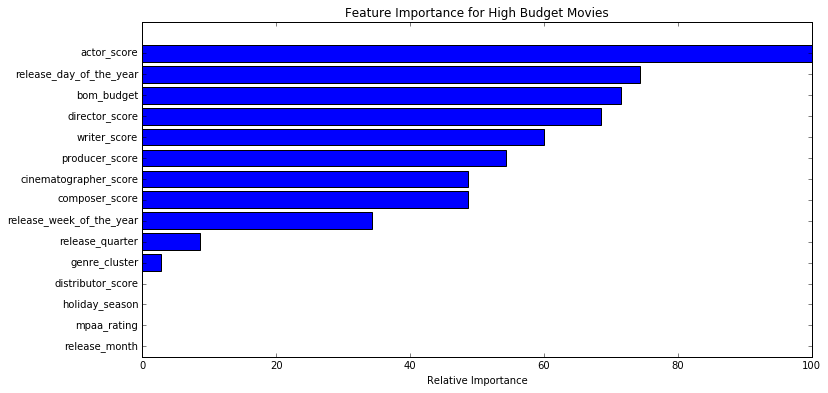

In [12]:
high_rmse,high_r2 = gradient_booster_tester(high_budget_x,high_budget_y,200,1,0.1)
print("Root Mean squared error: %.2f" % high_rmse)
print('R squared: %.3f' % high_r2)

final_high_model = build_final_model(high_budget_x,high_budget_y,200,1,0.1)
plot_feature_importance(final_high_model.feature_importances_, high_budget_x, "High Budget")

##### Serialize the Model

In [14]:
pickle.dump(final_low_model, open('model/low_budget.mprophet', 'wb'), protocol=0)
pickle.dump(final_mid_model, open('model/mid_budget.mprophet', 'wb'), protocol=0)
pickle.dump(final_high_model, open('model/high_budget.mprophet', 'wb'), protocol=0)